In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
passwords <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-14/passwords.csv') %>% 
                filter(!is.na(rank)) %>% 
                mutate(pass_length = nchar(password), 
                       contains_letters = str_detect(password, '[:lower:]'), 
                       contains_numbers = str_detect(password, '[:digit:]'), 
                       contains_both = contains_letters & contains_numbers)

Parsed with column specification:
cols(
  rank = col_double(),
  password = col_character(),
  category = col_character(),
  value = col_double(),
  time_unit = col_character(),
  offline_crack_sec = col_double(),
  rank_alt = col_double(),
  strength = col_double(),
  font_size = col_double()
)



In [3]:
write_csv(passwords, "passwords.csv")

# Distribución del largo de los passwords

Los passwords mas largos son mas difíciles de descifrar según esta métrica:

In [23]:
passwords %>% 
    group_by(time_unit) %>% 
    summarise(mean_length = mean(pass_length), sd_length = sd(pass_length)) %>% 
    arrange(-mean_length)

time_unit,mean_length,sd_length
<chr>,<dbl>,<dbl>
years,7.923077,0.2685431
months,7.000000,0.0000000
weeks,6.600000,1.3416408
days,6.037815,0.2952483
hours,5.139535,0.5155393
minutes,4.745098,0.9558899
seconds,4.000000,0.0000000


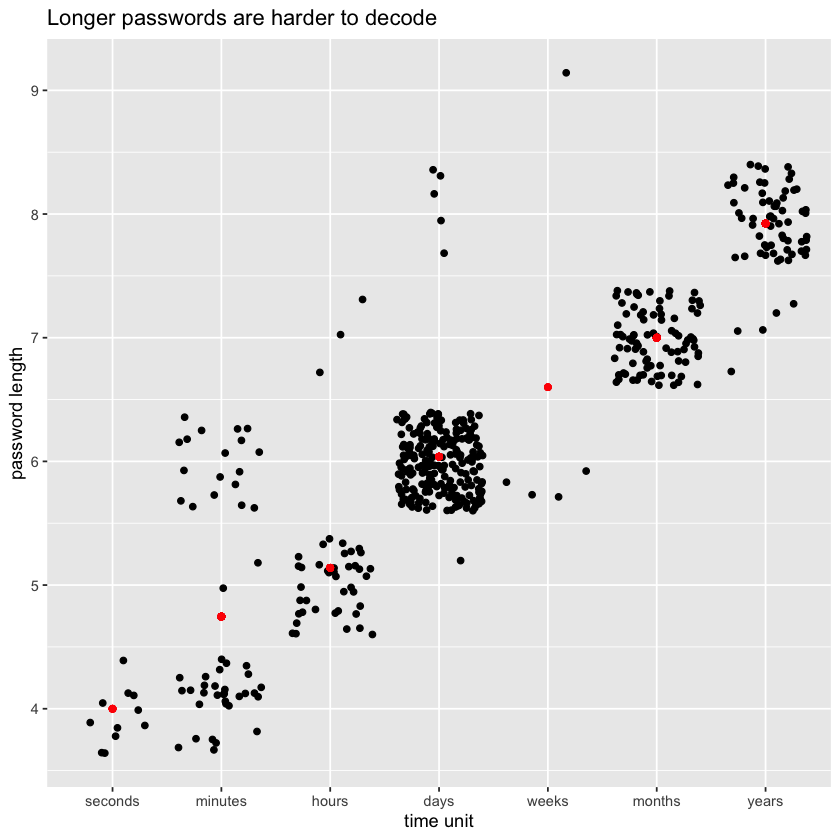

In [30]:
passwords %>% 
    group_by(time_unit) %>% 
    mutate(mean_length = mean(pass_length)) %>% 
    ungroup() %>% 
    mutate(time_unit = fct_reorder(time_unit, mean_length)) %>% 
    ggplot(aes(time_unit, pass_length)) +
        geom_jitter() +
        geom_point(aes(time_unit, mean_length), color = 'red') +
        labs(title = 'Longer passwords are harder to decode', 
             x = 'time unit', y = 'password length')

# Popularidad y seguridad

Hay passwords populares que son seguros. La distribución de strength no parace cambiar en función del rank.

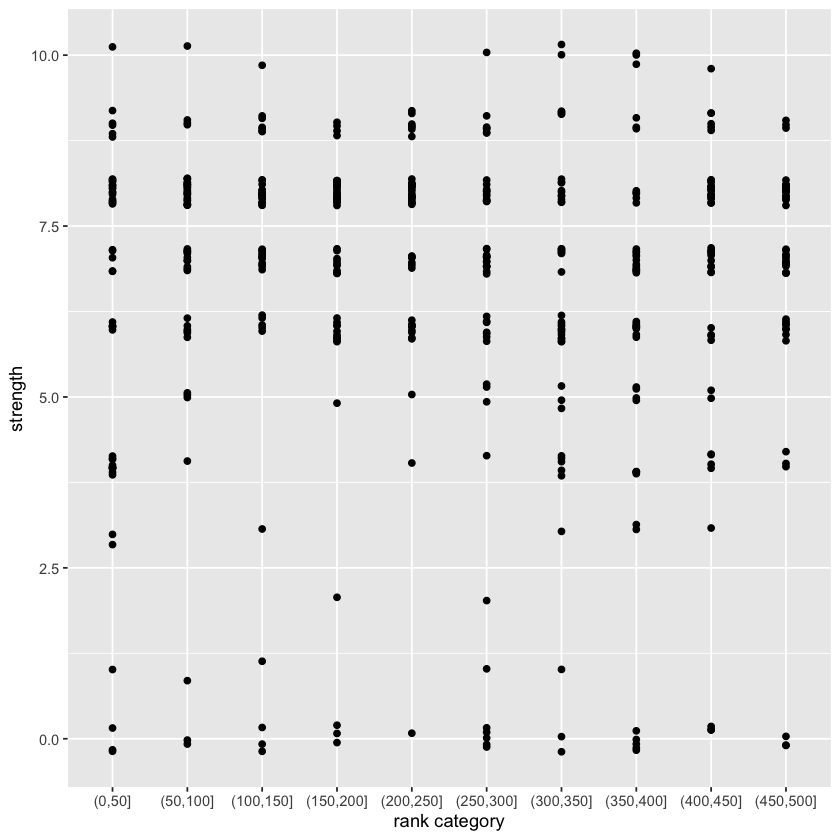

In [31]:
passwords %>% 
    filter(strength <= 10) %>%
    mutate(rank_cat = cut(rank, seq(0, 550, 50))) %>% 
    ggplot(aes(rank_cat, strength)) +
        geom_jitter(width = 0, height = 0.2) +
        labs(x = 'rank category')

# Letras, números o letras y números?

letras ≤ números < letras y números

In [32]:
passwords %>% 
    select(strength, contains_letters, contains_numbers, contains_both) %>% 
    pivot_longer(-strength, names_to = "type", values_to = "value") %>% 
    filter(value == TRUE) %>% 
    group_by(type) %>% 
    summarise(n = n(), 
              mean_strength = mean(strength), 
              sd_strength = sd(strength)) %>% 
    mutate(mean_strength = round(mean_strength, 0), 
           sd_strength = round(sd_strength, 0)) %>% 
    arrange(-mean_strength)

type,n,mean_strength,sd_strength
<chr>,<int>,<dbl>,<dbl>
contains_both,14,35,8
contains_numbers,54,11,15
contains_letters,460,8,5


# ¿Cómo funciona la calculadora?

In [42]:
# La calculadora busca de todas la palabras en el espacio de las palabras de 
# dos o menos letras

n_no_mas_de_2 <- 26^2 + 26
n_no_mas_de_2

# Luego asume que puedo adivinar 1000 palabras/segundo, entonces me demoro:

n_no_mas_de_2/1000 # segundos 

# Para el password 1a pueden hacer un cálculo similar, la única diferencia es que el tamaño
# del abecedario ahora es mas grande porque incluye números:

n_no_mas_de_2 <- (26 + 10)^2 + (26 + 10)
n_no_mas_de_2

n_no_mas_de_2/1000

[1] 702

[1] 0.702

[1] 1332

[1] 1.332

In [74]:
# este método se demora lo mismo en aa y ab porque son passwords con el mismo tamaño y 
# abecedario porque es una búsqueda es exaustiva.

# Una forma de pensar en la calculadora es decir 
# que usa una distribución uniforme. Si adivinaramos de manera aleatoria uniforme 
#la probabilidad de encontrar aa es:

1/702

# luego si puedo adivinar 1000 palabras por segundo, voy a dar con el password 
# original con probabilidad 1 ¿Cuál es el tiempo promedio para adivinar aa?


p_guessing <- function(n_rep, n_guesses){ 
        contains <- rep(NA, n_rep)
        for(i in 1:n_rep){
            s <- sample(1:702, n_guesses, replace = FALSE)
            contains[i] <- 702 %in% s
        }

        return(length(contains[contains == TRUE])/n_rep)
}

[1] 0.001424501

In [75]:
n_rep <- 10000
n_guesses  <- 400
p_guessing(n_rep, n_guesses)

[1] 0.563

In [76]:
n_rep <- 10000

P_guessing <- rep(NA, 702)

for(i in 1:702){
    n_guesses <- i 
    P_guessing[i] <- p_guessing(n_rep, n_guesses)
}

In [80]:
tibble(guesses = 1:702, proba = P_guessing) %>% 
    mutate(avg =guesses*proba) %>% 
    summarise(mean(avg))

# en promedio me voy a usar 234 intentos que en segundos es 234/1000. 
# Lo que reportan en la calculadora es el valor para que la proba sea 1.

mean(avg)
<dbl>
234.4191
